<a href="https://colab.research.google.com/github/aidaazzahraa/Sentiment-Analysis-on-TripAdvisor-Reviews/blob/main/Sentiment-Analysis-on-Tripadvisor-Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Sentiment Analysis on Tripadvisor Reviews**



**Information Retrieval - Text Classification** <br> Aida Azzahra <br>
1519622008 <br>


# **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

In [ ]:
!pip -q install sastrawi

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Acquisition

In [ ]:
!pip install kagglehub

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"aidaazzahraa123","key":"2e7ffb43ff4ad0014c42a34d947cce34"}'}

In [ ]:
import kagglehub

# Unduh dataset terbaru
path = kagglehub.dataset_download("ilhamfp31/dataset-tripadvisor")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ilhamfp31/dataset-tripadvisor/versions/1


In [ ]:
import os

path = "/root/.cache/kagglehub/datasets/ilhamfp31/dataset-tripadvisor/versions/1"
print(os.listdir(path))

['test_set.csv', 'train_set.csv']


In [ ]:
# Memuat dataset TripAdvisor dari folder train_set dan test_set
train_data = pd.read_csv(os.path.join(path, 'train_set.csv'))
test_data = pd.read_csv(os.path.join(path, 'test_set.csv'))

In [ ]:
print("Train Data Info:")
print(train_data.info())

print("\nTest Data Info:")
print(test_data.info())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12389 entries, 0 to 12388
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   12389 non-null  object
 1   polarity  12389 non-null  object
dtypes: object(2)
memory usage: 193.7+ KB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2429 entries, 0 to 2428
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   2429 non-null   object
 1   polarity  2429 non-null   object
dtypes: object(2)
memory usage: 38.1+ KB
None


In [ ]:
# Mengecek distribusi label polaritas pada Train Set
print('Total Review di Train Set:', train_data.shape[0], 'data\n')
print('Distribusi Label:')
print('-- Positif:', train_data[train_data.polarity == 'positive'].shape[0], 'data')
print('-- Negatif:', train_data[train_data.polarity == 'negative'].shape[0], 'data\n')

Total Review di Train Set: 12389 data

Distribusi Label:
-- Positif: 6281 data
-- Negatif: 6108 data



In [ ]:
# Mengecek distribusi label polaritas pada Test Set
print('Total Review di Test Set:', test_data.shape[0], 'data\n')
print('Distribusi Label:')
print('-- Positif:', test_data[test_data.polarity == 'positive'].shape[0], 'data')
print('-- Negatif:', test_data[test_data.polarity == 'negative'].shape[0], 'data\n')

Total Review di Test Set: 2429 data

Distribusi Label:
-- Positif: 1125 data
-- Negatif: 1304 data



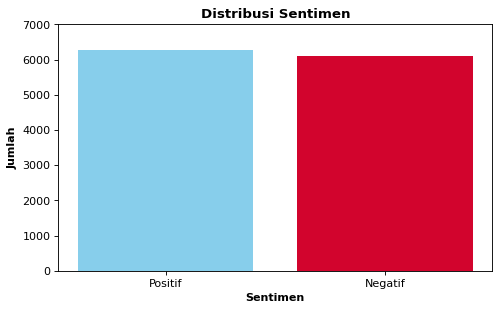

In [ ]:
# Visualisasi distribusi polaritas
height = train_data['polarity'].value_counts()
labels = ('Positif', 'Negatif')
y_pos = np.arange(len(labels))
plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,7000)
plt.title('Distribusi Sentimen', fontweight='bold')
plt.xlabel('Sentimen', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['skyblue', '#d2042d'])
plt.xticks(y_pos, labels)
plt.show()

# **Data Prepocessing**

## **Case Folding**

In [ ]:
# Case Folding (menjadikan semua teks huruf kecil dan menghapus karakter tidak penting)
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [ ]:
raw_sample = train_data['content'].iloc[1]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  ada tidak ada pantai dan <number> menit berjalan kaki ke adalah pantai kuta matahari terbenam yang indah tapi terlalu mahal untuk apa yang anda dapatkan hotel ini adalah definisi yang tua daerah di sekitar hotel tampak sedikit usang dan mereka berpura pura seperti <number> tahun yang lalu adalah puncak mereka masih terjadi sarapan adalah tidak ada yang istimewa dibandingkan dengan hotel
Case folding	:  ada tidak ada pantai dan number menit berjalan kaki ke adalah pantai kuta matahari terbenam yang indah tapi terlalu mahal untuk apa yang anda dapatkan hotel ini adalah definisi yang tua daerah di sekitar hotel tampak sedikit usang dan mereka berpura pura seperti number tahun yang lalu adalah puncak mereka masih terjadi sarapan adalah tidak ada yang istimewa dibandingkan dengan hotel


## **Word Normalization**

In [ ]:
# Download corpus singkatan
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

--2024-11-18 16:14:15--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80969 (79K) [text/plain]
Saving to: ‘key_norm.csv.1’

key_norm.csv.1      100%[===================>]  79.07K  --.-KB/s    in 0.02s   

2024-11-18 16:14:15 (4.80 MB/s) - ‘key_norm.csv.1’ saved [80969/80969]



In [ ]:
key_norm = pd.read_csv('key_norm.csv')

def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

## **Filtering (Stopword Removal)**

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [ ]:
len(stopwords_ind)

758

In [ ]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

In [ ]:
# Melihat 20 kata paling sering muncul setelah case folding
from collections import Counter

# Gabungkan semua kata dalam satu list setelah case folding
all_words = ' '.join(train_data['content'].apply(casefolding)).split()

# Hitung frekuensi kata
word_freq = Counter(all_words)

# Tampilkan 20 kata yang paling sering muncul
print(word_freq.most_common(20))

[('yang', 20252), ('dan', 18984), ('di', 16209), ('untuk', 11670), ('tidak', 11129), ('saya', 10361), ('kami', 9546), ('ini', 8798), ('number', 7513), ('dengan', 7493), ('hotel', 7306), ('kamar', 7185), ('sangat', 6900), ('ada', 4591), ('adalah', 4498), ('dari', 4298), ('makanan', 3765), ('ke', 3707), ('tempat', 3698), ('tapi', 3628)]


In [ ]:
# Contoh penambahan stopword sesuai hasil
more_stopword = ['number', 'nomor']
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

# Terapkan pada kolom teks
train_data['content'] = train_data['content'].apply(remove_stop_words)

In [ ]:
raw_sample = train_data['content'].iloc[1]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  pantai <number> menit berjalan kaki pantai kuta matahari terbenam indah mahal dapatkan hotel definisi tua daerah hotel usang berpura pura <number> puncak sarapan istimewa dibandingkan hotel
Case folding		:  pantai number menit berjalan kaki pantai kuta matahari terbenam indah mahal dapatkan hotel definisi tua daerah hotel usang berpura pura number puncak sarapan istimewa dibandingkan hotel
Stopword removal	:  pantai menit berjalan kaki pantai kuta matahari terbenam indah mahal dapatkan hotel definisi tua daerah hotel usang berpura pura puncak sarapan istimewa dibandingkan hotel


## **Stemming**

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [ ]:
raw_sample = train_data['content'].iloc[1]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  pantai <number> menit berjalan kaki pantai kuta matahari terbenam indah mahal dapatkan hotel definisi tua daerah hotel usang berpura pura <number> puncak sarapan istimewa dibandingkan hotel
Case folding		:  pantai number menit berjalan kaki pantai kuta matahari terbenam indah mahal dapatkan hotel definisi tua daerah hotel usang berpura pura number puncak sarapan istimewa dibandingkan hotel
Stopword removal	:  pantai menit berjalan kaki pantai kuta matahari terbenam indah mahal dapatkan hotel definisi tua daerah hotel usang berpura pura puncak sarapan istimewa dibandingkan hotel
Stemming		:  pantai menit jalan kaki pantai kuta matahari benam indah mahal dapat hotel definisi tua daerah hotel usang pura pura puncak sarap istimewa banding hotel


In [ ]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [ ]:
%%time
train_data['clean_content'] = train_data['content'].apply(text_preprocessing_process)
test_data['clean_content'] = test_data['content'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: user 4min 29s, sys: 5.19 s, total: 4min 34s
Wall time: 4min 42s


In [ ]:
train_data

,content,polarity,clean_content
0,<number> ruangan <number> 30 jam <number> berp...,negative,ruang jam pikir serius bersih butuh baik suara...
1,pantai <number> menit berjalan kaki pantai kut...,negative,pantai menit jalan kaki pantai kuta matahari b...
2,restoran perbaikan pemberitahuan mengambil fot...,negative,restoran baik pemberitahuan ambil foto jelek b...
3,restoran perbaikan pemberitahuan mengambil fot...,negative,restoran baik pemberitahuan ambil foto jelek b...
4,bilang harga boong harga barang kutipan kutipa...,negative,bilang harga bohong harga barang kutip kutip l...
...,...,...,...
12384,zangrandi gm p <number> maret <number> ranch m...,positive,zangrandi gm p maret ranch market galaxy mall ...
12385,zeer gud erg vriendelijk personeel denken gud ...,positive,zeer gud erg vriendelijk personeel denken gud ...
12386,zenbu mengedepankan makanan jepang fusion unik...,positive,zenbu depan makan jepang fusion unik ukur keny...
12387,zenbu jenis restaurant jepang menyajikan menu ...,positive,zenbu jenis restaurant jepang saji menu makan ...


In [ ]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
train_data.to_csv('clean_train_data.csv')
test_data.to_csv('clean_test_data.csv')

# **Feature Engineering**

In [ ]:
# Pisahkan kolom feature dan target
X_train = train_data['clean_content']
y_train = train_data['polarity'].map({'positive': 1, 'negative': 0})  # Label biner untuk klasifikasi
X_test = test_data['clean_content']
y_test = test_data['polarity'].map({'positive': 1, 'negative': 0})

In [ ]:
X_train

,clean_content
0,ruang jam pikir serius bersih butuh baik suara...
1,pantai menit jalan kaki pantai kuta matahari b...
2,restoran baik pemberitahuan ambil foto jelek b...
3,restoran baik pemberitahuan ambil foto jelek b...
4,bilang harga bohong harga barang kutip kutip l...
...,...
12384,zangrandi gm p maret ranch market galaxy mall ...
12385,zeer gud erg vriendelijk personeel denken gud ...
12386,zenbu depan makan jepang fusion unik ukur keny...
12387,zenbu jenis restaurant jepang saji menu makan ...


In [ ]:
y_train

,polarity
0,0
1,0
2,0
3,0
4,0
...,...
12384,1
12385,1
12386,1
12387,1


## **Feature Extraction (Bag of Words & N-Gram)**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# BoW - Unigram
bow = CountVectorizer(ngram_range=(1,1))
bow.fit(X_train)

CountVectorizer()

In [ ]:
# Melihat Jumlah Fitur
print(len(bow.get_feature_names_out()))

14346


In [ ]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(bow.get_feature_names_out())

['aacara' 'aakan' 'aam' ... 'zwar' 'zwei' 'zwembad']


In [ ]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

# Transformasi ke matriks BoW
X_train_bow = bow.transform(X_train).toarray()
X_test_bow = bow.transform(X_test).toarray()

In [ ]:
# Simpan matriks BoW menggunakan pickle
with open('bow_feature_train.pickle', 'wb') as output:
    pickle.dump(X_train_bow, output)
with open('bow_feature_test.pickle', 'wb') as output:
    pickle.dump(X_test_bow, output)

## **Feature Extraction (TF-IDF & N-Gram)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X_train)

TfidfVectorizer()

In [ ]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

14346


In [ ]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['aacara' 'aakan' 'aam' ... 'zwar' 'zwei' 'zwembad']


In [ ]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

# Transform data train dan test
X_train_tf_idf = tf_idf.transform(X_train).toarray()
X_test_tf_idf = tf_idf.transform(X_test).toarray()

In [ ]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

# Untuk data train
data_train_tf_idf = pd.DataFrame(X_train_tf_idf, columns=tf_idf.get_feature_names_out())
print("Data TF-IDF Train:")
print(data_train_tf_idf.head())  # Melihat beberapa baris awal

Data TF-IDF Train:
   aacara  aakan  aam  aamazing  aampun  aan  aangatlah  aangenaam  aankomst  \
0     0.0    0.0  0.0       0.0     0.0  0.0        0.0        0.0       0.0   
1     0.0    0.0  0.0       0.0     0.0  0.0        0.0        0.0       0.0   
2     0.0    0.0  0.0       0.0     0.0  0.0        0.0        0.0       0.0   
3     0.0    0.0  0.0       0.0     0.0  0.0        0.0        0.0       0.0   
4     0.0    0.0  0.0       0.0     0.0  0.0        0.0        0.0       0.0   

   aankwamen  ...  zufrieden  zum  zumos  zun  zupa  zuppa  zuri  zwar  zwei  \
0        0.0  ...        0.0  0.0    0.0  0.0   0.0    0.0   0.0   0.0   0.0   
1        0.0  ...        0.0  0.0    0.0  0.0   0.0    0.0   0.0   0.0   0.0   
2        0.0  ...        0.0  0.0    0.0  0.0   0.0    0.0   0.0   0.0   0.0   
3        0.0  ...        0.0  0.0    0.0  0.0   0.0    0.0   0.0   0.0   0.0   
4        0.0  ...        0.0  0.0    0.0  0.0   0.0    0.0   0.0   0.0   0.0   

   zwembad  
0     

In [ ]:
# Untuk data test
data_test_tf_idf = pd.DataFrame(X_test_tf_idf, columns=tf_idf.get_feature_names_out())
print("Data TF-IDF Test:")
print(data_test_tf_idf.head())  # Melihat beberapa baris awal

Data TF-IDF Test:
   aacara  aakan  aam  aamazing  aampun  aan  aangatlah  aangenaam  aankomst  \
0     0.0    0.0  0.0       0.0     0.0  0.0        0.0        0.0       0.0   
1     0.0    0.0  0.0       0.0     0.0  0.0        0.0        0.0       0.0   
2     0.0    0.0  0.0       0.0     0.0  0.0        0.0        0.0       0.0   
3     0.0    0.0  0.0       0.0     0.0  0.0        0.0        0.0       0.0   
4     0.0    0.0  0.0       0.0     0.0  0.0        0.0        0.0       0.0   

   aankwamen  ...  zufrieden  zum  zumos  zun  zupa  zuppa  zuri  zwar  zwei  \
0        0.0  ...        0.0  0.0    0.0  0.0   0.0    0.0   0.0   0.0   0.0   
1        0.0  ...        0.0  0.0    0.0  0.0   0.0    0.0   0.0   0.0   0.0   
2        0.0  ...        0.0  0.0    0.0  0.0   0.0    0.0   0.0   0.0   0.0   
3        0.0  ...        0.0  0.0    0.0  0.0   0.0    0.0   0.0   0.0   0.0   
4        0.0  ...        0.0  0.0    0.0  0.0   0.0    0.0   0.0   0.0   0.0   

   zwembad  
0      

In [ ]:
# Simpan TF-IDF feature ke file
with open('tf_idf_feature_train.pickle', 'wb') as output:
    pickle.dump(X_train_tf_idf, output)
with open('tf_idf_feature_test.pickle', 'wb') as output:
    pickle.dump(X_test_tf_idf, output)

## **Feature Selection**

In [ ]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X_train = np.array(data_train_tf_idf)  # Data Train
y_train = np.array(y_train)  # Target Train

X_test = np.array(data_test_tf_idf)  # Data Test
y_test = np.array(y_test)  # Target Test

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Seleksi fitur dengan Chi-Square pada data train
chi2_features = SelectKBest(chi2, k=1000)
X_train_kbest = chi2_features.fit_transform(X_train, y_train)

# Terapkan fitur yang terpilih dari train ke data test
X_test_kbest = chi2_features.transform(X_test)

# Menampilkan jumlah fitur awal dan setelah seleksi
print('Original feature number (train):', X_train.shape[1])
print('Reduced feature number (train):', X_train_kbest.shape[1])
print('Original feature number (test):', X_test.shape[1])
print('Reduced feature number (test):', X_test_kbest.shape[1])

Original feature number (train): 14346
Reduced feature number (train): 1000
Original feature number (test): 14346
Reduced feature number (test): 1000


In [ ]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
# Menampilkan skor Chi-Square dari fitur
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2 = data_chi2.sort_values(by='nilai', ascending=False)
print(data_chi2.head(10))  # Fitur terbaik

            nilai   fitur
1919   137.761359   buruk
3635   102.638162    enak
6741    97.716330   kotor
6006    89.449554   kamar
8121    89.316805     mes
13866   88.883030  warung
6180    62.509858  kecewa
9554    57.938674   pergi
1112    57.852289     bau
975     54.590248  banget


In [ ]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([False, False, False, ..., False, False, False])

In [ ]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['abai',
 'abu',
 'ac',
 'acak',
 'accor',
 'aceh',
 'acuh',
 'adem',
 'aga',
 'agam',
 'agen',
 'agoda',
 'agustus',
 'air',
 'ajak',
 'aku',
 'alam',
 'alami',
 'alarm',
 'alas',
 'alhasil',
 'alkohol',
 'alun',
 'aman',
 'ambil',
 'ampera',
 'and',
 'andal',
 'aneh',
 'aneka',
 'anggota',
 'angkring',
 'another',
 'antri',
 'anya',
 'apa',
 'apak',
 'apek',
 'april',
 'arah',
 'arogan',
 'asal',
 'asik',
 'asri',
 'asyik',
 'atap',
 'atur',
 'aud',
 'australia',
 'awat',
 'ayam',
 'baca',
 'bacem',
 'bagasi',
 'bahari',
 'bahasa',
 'bahaya',
 'bak',
 'bakar',
 'bakmi',
 'bakpia',
 'bakso',
 'bakwan',
 'bal',
 'balikpapan',
 'balkon',
 'bandara',
 'bandeng',
 'bandung',
 'banget',
 'banjir',
 'bantal',
 'bantul',
 'bao',
 'bar',
 'barang',
 'bareng',
 'barong',
 'bartender',
 'baru',
 'basah',
 'basi',
 'batal',
 'batas',
 'bau',
 'bawa',
 'bayang',
 'bayar',
 'bca',
 'beban',
 'bebek',
 'bed',
 'bekas',
 'beku',
 'belanja',
 'belok',
 'bencana',
 'berangkat',
 'beranta',
 'berat',
 

In [ ]:
tf_idf.vocabulary_

{'ruang': 10830,
 'jam': 5651,
 'pikir': 9669,
 'serius': 11502,
 'bersih': 1373,
 'butuh': 1943,
 'baik': 871,
 'suara': 12212,
 'timbang': 12957,
 'hotel': 5095,
 'pergi': 9554,
 'anak': 418,
 'sempit': 11395,
 'bintang': 1517,
 'nikmat': 8702,
 'lingkung': 7283,
 'kecuali': 6189,
 'mabuk': 7509,
 'pantai': 9250,
 'menit': 8046,
 'jalan': 5640,
 'kaki': 5972,
 'kuta': 6903,
 'matahari': 7820,
 'benam': 1267,
 'indah': 5338,
 'mahal': 7551,
 'dapat': 2738,
 'definisi': 2846,
 'tua': 13256,
 'daerah': 2681,
 'usang': 13555,
 'pura': 10093,
 'puncak': 10080,
 'sarap': 11088,
 'istimewa': 5564,
 'banding': 960,
 'restoran': 10594,
 'pemberitahuan': 9470,
 'ambil': 380,
 'foto': 4088,
 'jelek': 5754,
 'biaya': 1463,
 'euro': 3777,
 'layak': 7084,
 'serangga': 11481,
 'lemari': 7163,
 'diberitahu': 3003,
 'staf': 12079,
 'periksa': 9559,
 'kamar': 6006,
 'malam': 7621,
 'bilang': 1489,
 'harga': 4820,
 'bohong': 1631,
 'barang': 1030,
 'kutip': 6907,
 'laku': 6970,
 'warna': 13859,
 'kulit

In [ ]:
# Lihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [ ]:
kbest_feature

{'ruang': 10830,
 'jam': 5651,
 'pikir': 9669,
 'serius': 11502,
 'butuh': 1943,
 'suara': 12212,
 'timbang': 12957,
 'hotel': 5095,
 'pergi': 9554,
 'sempit': 11395,
 'bintang': 1517,
 'nikmat': 8702,
 'mabuk': 7509,
 'menit': 8046,
 'indah': 5338,
 'mahal': 7551,
 'dapat': 2738,
 'tua': 13256,
 'usang': 13555,
 'pura': 10093,
 'restoran': 10594,
 'pemberitahuan': 9470,
 'ambil': 380,
 'foto': 4088,
 'jelek': 5754,
 'biaya': 1463,
 'layak': 7084,
 'serangga': 11481,
 'lemari': 7163,
 'diberitahu': 3003,
 'staf': 12079,
 'periksa': 9559,
 'kamar': 6006,
 'malam': 7621,
 'harga': 4820,
 'barang': 1030,
 'kutip': 6907,
 'laku': 6970,
 'asal': 640,
 'layan': 7086,
 'buruk': 1919,
 'bocor': 1623,
 'ac': 55,
 'server': 11517,
 'kasir': 6119,
 'ramah': 10209,
 'pandang': 9225,
 'minum': 8223,
 'keras': 6363,
 'bar': 1026,
 'ganggu': 4246,
 'bayar': 1133,
 'kecewa': 6180,
 'pm': 9782,
 'cek': 2115,
 'in': 5323,
 'suguh': 12242,
 'klub': 6561,
 'saji': 10926,
 'selesai': 11342,
 'kering': 6373

In [ ]:
# Menyimpan fitur terpilih untuk model
selected_features = [f for f, m in zip(tf_idf.get_feature_names_out(), chi2_features.get_support()) if m]

data_train_selected = pd.DataFrame(X_train_kbest, columns=selected_features)
data_test_selected = pd.DataFrame(X_test_kbest, columns=selected_features)

In [ ]:
# Simpan fitur terpilih dalam file pickle
with open('kbest_feature_train.pickle', 'wb') as output:
    pickle.dump(data_train_selected, output)
with open('kbest_feature_test.pickle', 'wb') as output:
    pickle.dump(data_test_selected, output)

# **Modelling (Machine Learning)**

In [ ]:
# Data train dan test
X_train = data_train_selected
y_train = y_train  # Target untuk data train
X_test = data_test_selected
y_test = y_test  # Target untuk data test

## **Model 1: Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from joblib import dump

# Inisialisasi model Naive Bayes
nb_model = MultinomialNB()

# Training model Naive Bayes
nb_model.fit(X_train, y_train)

# Simpan model
dump(nb_model, filename='nb_model.joblib')

# Prediksi data uji
nb_pred = nb_model.predict(X_test)

## **Evaluasi Naive Bayes**

In [ ]:
# Prediksi dengan Naive Bayes
nb_pred = nb_model.predict(X_test)

# Hitung jumlah prediksi benar dan salah
prediksi_benar_nb = (nb_pred == y_test).sum()
prediksi_salah_nb = (nb_pred != y_test).sum()

print('Naive Bayes:')
print('Jumlah prediksi benar\t:', prediksi_benar_nb)
print('Jumlah prediksi salah\t:', prediksi_salah_nb)

accuracy_nb = prediksi_benar_nb / (prediksi_benar_nb + prediksi_salah_nb) * 100
print('Accuracy pengujian\t:', accuracy_nb, '%')

Naive Bayes:
Jumlah prediksi benar	: 1873
Jumlah prediksi salah	: 556
Accuracy pengujian	: 77.10992177850967 %


In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm_nb = confusion_matrix(y_test, nb_pred)
print('Confusion Matrix:\n', cm_nb)

Confusion Matrix:
 [[977 327]
 [229 896]]


In [ ]:
from sklearn.metrics import classification_report

# Classification Report
print('Classification report:\n', classification_report(y_test, nb_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78      1304
           1       0.73      0.80      0.76      1125

    accuracy                           0.77      2429
   macro avg       0.77      0.77      0.77      2429
weighted avg       0.77      0.77      0.77      2429



In [ ]:
# Cross Validation untuk Naive Bayes
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import numpy as np

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy_nb = cross_val_score(nb_model, X_train_kbest, y_train, cv=cv, scoring='accuracy')
avg_accuracy_nb = np.mean(cv_accuracy_nb)

print('Accuracy setiap split (Naive Bayes):', cv_accuracy_nb, '\n')
print('Rata-rata Accuracy cross validation (Naive Bayes):', avg_accuracy_nb)

Accuracy setiap split (Naive Bayes): [0.84543987 0.84987893 0.84342211 0.8385795  0.82001614 0.84059726
 0.83898305 0.83535109 0.84422922 0.83091203] 

Rata-rata Accuracy cross validation (Naive Bayes): 0.8387409200968523


## **Model 2: Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

# Inisialisasi model Logistic Regression
lr_model = LogisticRegression(random_state=40, max_iter=1000)

# Training model Logistic Regression
lr_model.fit(X_train, y_train)

# Simpan model
dump(lr_model, filename='lr_model.joblib')

# Prediksi data uji
lr_pred = lr_model.predict(X_test)

## **Evaluasi Logistic Regression**

In [ ]:
# Prediksi dengan LR
lr_pred = lr_model.predict(X_test)

# Hitung jumlah prediksi benar dan salah
prediksi_benar_lr = (lr_pred == y_test).sum()
prediksi_salah_lr = (lr_pred != y_test).sum()

print('\nLR:')
print('Jumlah prediksi benar\t:', prediksi_benar_lr)
print('Jumlah prediksi salah\t:', prediksi_salah_lr)

accuracy_lr = prediksi_benar_lr / (prediksi_benar_lr + prediksi_salah_lr) * 100
print('Accuracy pengujian\t:', accuracy_lr, '%')


LR:
Jumlah prediksi benar	: 1943
Jumlah prediksi salah	: 486
Accuracy pengujian	: 79.99176615891314 %


In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm_lr = confusion_matrix(y_test, lr_pred)
print('Confusion matrix:\n', cm_lr)

Confusion matrix:
 [[978 326]
 [160 965]]


In [ ]:
from sklearn.metrics import classification_report

# Classification Report
print('Classification report:\n', classification_report(y_test, lr_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80      1304
           1       0.75      0.86      0.80      1125

    accuracy                           0.80      2429
   macro avg       0.80      0.80      0.80      2429
weighted avg       0.81      0.80      0.80      2429



In [ ]:
# Cross Validation untuk LR
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import numpy as np

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy_lr = cross_val_score(lr_model, X_train_kbest, y_train, cv=cv, scoring='accuracy')
avg_accuracy_lr = np.mean(cv_accuracy_lr)

print('Accuracy setiap split (LR):', cv_accuracy_lr, '\n')
print('Rata-rata Accuracy cross validation (LR):', avg_accuracy_lr)

Accuracy setiap split (LR): [0.8551251  0.86602098 0.85714286 0.8551251  0.83535109 0.84503632
 0.85552865 0.86158192 0.85270379 0.85108959] 

Rata-rata Accuracy cross validation (LR): 0.8534705407586763


## **Model 3: Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Inisialisasi model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=40)

# Training model Random Forest
rf_model.fit(X_train, y_train)

# Simpan model
dump(rf_model, filename='rf_model.joblib')

# Prediksi data uji
rf_pred = rf_model.predict(X_test)

## **Evaluasi Random Forest**

In [ ]:
# Prediksi dengan Random Forest
rf_pred = rf_model.predict(X_test)

# Hitung jumlah prediksi benar dan salah
prediksi_benar_rf = (rf_pred == y_test).sum()
prediksi_salah_rf = (rf_pred != y_test).sum()

print('\nRandom Forest:')
print('Jumlah prediksi benar\t:', prediksi_benar_rf)
print('Jumlah prediksi salah\t:', prediksi_salah_rf)

accuracy_rf = prediksi_benar_rf / (prediksi_benar_rf + prediksi_salah_rf) * 100
print('Accuracy pengujian\t:', accuracy_rf, '%')


Random Forest:
Jumlah prediksi benar	: 1902
Jumlah prediksi salah	: 527
Accuracy pengujian	: 78.3038287361054 %


In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_pred)
print('Confusion matrix:\n', cm_rf)

Confusion matrix:
 [[994 310]
 [217 908]]


In [ ]:
from sklearn.metrics import classification_report

# Classification Report
print('Classification report:\n', classification_report(y_test, rf_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79      1304
           1       0.75      0.81      0.78      1125

    accuracy                           0.78      2429
   macro avg       0.78      0.78      0.78      2429
weighted avg       0.79      0.78      0.78      2429



In [ ]:
# Cross Validation untuk Random Forest
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
import numpy as np

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy_rf = cross_val_score(rf_model, X_train_kbest, y_train, cv=cv, scoring='accuracy')
avg_accuracy_rf = np.mean(cv_accuracy_rf)

print('Accuracy setiap split (Random Forest):', cv_accuracy_rf, '\n')
print('Rata-rata Accuracy cross validation (Random Forest):', avg_accuracy_rf)

Accuracy setiap split (Random Forest): [0.88216303 0.88337369 0.88418079 0.8874092  0.87651332 0.87489911
 0.88458434 0.88095238 0.8866021  0.87933818] 

Rata-rata Accuracy cross validation (Random Forest): 0.882001614205004


# **Perbandingan Akurasi Tiap Model**

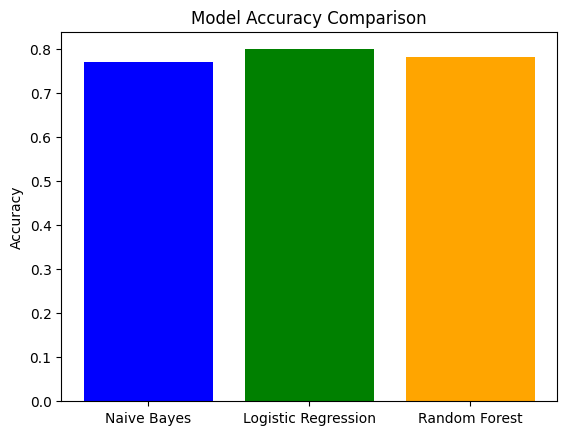

In [ ]:
import matplotlib.pyplot as plt

# Akurasi tiap model
accuracy_scores = {
    'Naive Bayes': accuracy_score(y_test, nb_pred),
    'Logistic Regression': accuracy_score(y_test, lr_pred),
    'Random Forest': accuracy_score(y_test, rf_pred)
}

# Plot akurasi
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Print akurasi setiap model
print("Hasil Akurasi Model:")
for model, acc in accuracy_scores.items():
    print(f"{model}: {acc:.4f}")  # Tampilkan hingga 4 desimal

Hasil Akurasi Model:
Naive Bayes: 0.7711
Logistic Regression: 0.7999
Random Forest: 0.7830


# **Deployment**

In [ ]:
from joblib import load

# load model
model = load('lr_model.joblib')

# load vocabulary dari TF_idf
vocab = pickle.load(open('kbest_feature_train.pickle', 'rb'))

In [ ]:
#@title Masukkan Teks Anda:
input_text = "Pelayanan hotel ramah" #@param {type:"string"}

pre_input_text = text_preprocessing_process(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result = lr_model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('Hasil Text Preprocessing :', pre_input_text)

if (result==1):
  sentiment = 'Positive'
elif (result==0):
  sentiment = 'Negatif'

print('Hasil Prediksi', 'adalah', sentiment)

Hasil Text Preprocessing : layan hotel ramah
Hasil Prediksi adalah Positive


# **Resume**

Proses analisis dimulai dengan text preprocessing untuk mempersiapkan data ulasan dari Tripadvisor. Tahap ini mencakup case folding (mengubah teks menjadi huruf kecil dan menghapus karakter tidak penting), word normalization (mengubah kata tidak baku menjadi baku), stopword removal (menghapus kata-kata umum yang tidak relevan), dan stemming (mengubah kata-kata berimbuhan menjadi bentuk dasar).

Setelah preprocessing, data diubah menjadi representasi numerik menggunakan teknik TF-IDF (Term Frequency-Inverse Document Frequency). Untuk memastikan hanya fitur yang relevan digunakan dalam pemodelan, teknik SelectKBest dengan skor chi-square diterapkan untuk memilih fitur terbaik.

Pada tahap modelling, tiga algoritma digunakan untuk melatih model yaitu Naive Bayes, Logistic Regression, dan Random Forest. Setiap model dilatih menggunakan data yang telah diproses dan kemudian dievaluasi menggunakan berbagai metrik untuk menilai performanya. Evaluasi mencakup akurasi, confusion matrix (untuk melihat distribusi prediksi benar dan salah), classification report (yang melibatkan metrik precision, recall, dan f1-score), serta cross-validation.

Hasil evaluasi menunjukkan bahwa setiap algoritma memiliki performa yang bervariasi: Naive Bayes menghasilkan akurasi sebesar 77.11%, Logistic Regression mencapai akurasi tertinggi yaitu 79.99%, dan Random Forest menghasilkan akurasi sebesar 78.30%,
Secara keseluruhan, Logistic Regression menunjukkan performa terbaik berdasarkan akurasi.

Untuk memudahkan interpretasi hasil, akurasi ketiga model dibandingkan menggunakan grafik batang. Sebagai langkah akhir, model Logistic Regression diterapkan untuk proses deployment. Model ini dikombinasikan dengan vocabulary yang dihasilkan dari TF-IDF, sehingga sistem dapat menerima input teks baru, melakukan preprocessing, dan memberikan prediksi sentimen secara otomatis.